In [2]:
from __future__ import annotations
from typing import List
import numpy as np
import pandas as pd

# Dynamic Signature Verification using Adapted Levenshtein Distance

This notebook implements dynamic (online) signature verification based on
Chapter 6 of the Image Processing lecture notes.

Pipeline:
- Load online signature data
- Segment into strokes (pen up / pen down)
- Encode strokes as symbolic strings using local extrema
- Compare signatures using adapted Levenshtein distance
- Normalize distance for verification

In [3]:
COLUMNS = ["x", "y", "t", "s"]
def load_signature(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, sep=r"\s+|,|;", engine="python", header=None)
    df = df.iloc[:, :len(COLUMNS)]
    df.columns = COLUMNS
    return df

In [4]:
df = pd.read_csv('/content/U3S40.TXT', sep=r"\s+|,|;", engine="python", header=None, names=COLUMNS)
df.head()

,x,y,t,s
0,348,NaN,NaN,NaN
1,3243,7375.0,73524292.0,0.0
2,3228,7466.0,73524302.0,1.0
3,3179,7514.0,73524312.0,1.0
4,3179,7545.0,73524322.0,1.0


In [5]:
# Remove rows with any NaN values
df_cleaned = df.dropna()

display(df_cleaned.head())

,x,y,t,s
1,3243,7375.0,73524292.0,0.0
2,3228,7466.0,73524302.0,1.0
3,3179,7514.0,73524312.0,1.0
4,3179,7545.0,73524322.0,1.0
5,3209,7564.0,73524332.0,1.0


In [6]:
print('Number of NaN values per column in df_cleaned:')
print(df_cleaned.isnull().sum())

Number of NaN values per column in df_cleaned:
x    0
y    0
t    0
s    0
dtype: int64


## Stroke segmentation

A stroke is a continuous sequence of points where the pen is down (s = 1).
Pen-up points separate strokes.

In [7]:
def segment_strokes(df: pd.DataFrame) -> List[pd.DataFrame]:
    strokes = []
    current = []

    for _, row in df.iterrows():
        if row["s"] == 1:
            current.append(row)
        else:
            if current:
                strokes.append(pd.DataFrame(current))
                current = []
    if current:
        strokes.append(pd.DataFrame(current))

    return strokes

## Local extrema detection

For each stroke, local minima and maxima are detected in x(t) and y(t).
These extrema are encoded as symbols:
- a : x_min
- b : x_max
- c : y_min
- d : y_max

In [8]:
def encode_stroke(stroke: pd.DataFrame) -> str:
    x = stroke["x"].to_numpy()
    y = stroke["y"].to_numpy()

    xm, xM = local_extrema(x)
    ym, yM = local_extrema(y)

    events = []
    for i in xm: events.append((i, "a"))
    for i in xM: events.append((i, "b"))
    for i in ym: events.append((i, "c"))
    for i in yM: events.append((i, "d"))

    events.sort(key=lambda e: e[0])
    return "".join(e[1] for e in events)

## Encode entire signature

Each signature becomes a sequence of stroke strings.

In [9]:
def encode_signature(df: pd.DataFrame) -> List[str]:
    strokes = segment_strokes(df)
    return [encode_stroke(s) for s in strokes]

## Classical Levenshtein distance (string level)

In [10]:
def levenshtein(s1: str, s2: str) -> int:
    if s1 == s2:
        return 0
    if not s1:
        return len(s2)
    if not s2:
        return len(s1)

    dp = list(range(len(s2) + 1))
    for i, c1 in enumerate(s1, 1):
        prev = dp[:]
        dp[0] = i
        for j, c2 in enumerate(s2, 1):
            cost = 0 if c1 == c2 else 1
            dp[j] = min(prev[j] + 1, dp[j-1] + 1, prev[j-1] + cost)
    return dp[-1]

## Adapted Levenshtein distance (signature level)

Operations:
- Insert stroke → length of stroke
- Delete stroke → length of stroke
- Replace stroke → Levenshtein distance of strings

In [11]:
def adapted_levenshtein(sig1: List[str], sig2: List[str]) -> int:
    n, m = len(sig1), len(sig2)
    D = np.zeros((n+1, m+1), dtype=int)

    for i in range(1, n+1):
        D[i,0] = D[i-1,0] + len(sig1[i-1])
    for j in range(1, m+1):
        D[0,j] = D[0,j-1] + len(sig2[j-1])

    for i in range(1, n+1):
        for j in range(1, m+1):
            D[i,j] = min(
                D[i-1,j] + len(sig1[i-1]),
                D[i,j-1] + len(sig2[j-1]),
                D[i-1,j-1] + levenshtein(sig1[i-1], sig2[j-1])
            )
    return D[n,m]

## Normalized distance and verification decision

In [12]:
def total_length(sig: List[str]) -> int:
    return sum(len(s) for s in sig)

def normalized_distance(sig1: List[str], sig2: List[str]) -> float:
    return adapted_levenshtein(sig1, sig2) / (total_length(sig1) + total_length(sig2))

## Final concept

- Convert dynamic signature → symbolic strings
- Compare using adapted Levenshtein distance
- Normalize distance
- Accept / reject based on threshold

This method is robust to natural writing variations and missing strokes.

## Visualize signatures (plots)

We plot:
1) Full signature trajectory (x vs y)
2) Strokes separated (pen-down segments)
3) Optional: time series x(t), y(t)

In [13]:
import matplotlib.pyplot as plt

In [14]:
def plot_signature_xy(df: pd.DataFrame, title: str = "Signature (x-y)") -> None:
    """
    Plot the full signature as x-y trajectory.
    If pen-up rows exist, they are ignored or plotted as separate segments in stroke plot.
    """
    if "x" not in df.columns or "y" not in df.columns:
        raise KeyError("DataFrame must contain columns: x, y")

    plt.figure()
    plt.plot(df["x"].to_numpy(), df["y"].to_numpy())
    plt.gca().invert_yaxis()  # common for screen/tablet coordinate systems
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.show()

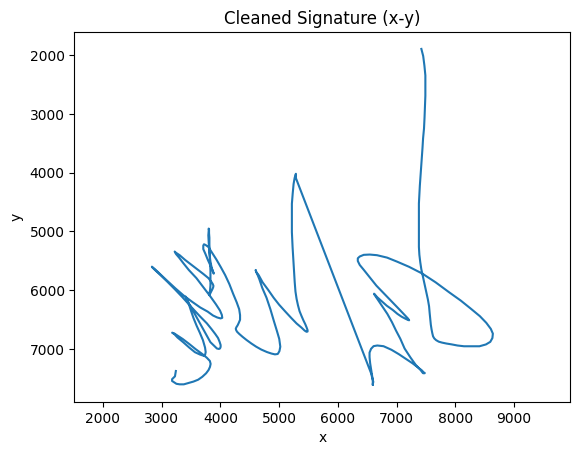

In [15]:
plot_signature_xy(df_cleaned, title="Cleaned Signature (x-y)")

In [16]:
def plot_strokes_xy(df: pd.DataFrame, title: str = "Signature Strokes (x-y)") -> None:
    """
    Plot each stroke (pen-down segment) in the signature.
    Strokes are plotted as separate polylines.
    """
    strokes = segment_strokes(df)

    plt.figure()
    for k, st in enumerate(strokes, start=1):
        plt.plot(st["x"].to_numpy(), st["y"].to_numpy(), label=f"stroke {k}")

    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.legend()
    plt.show()

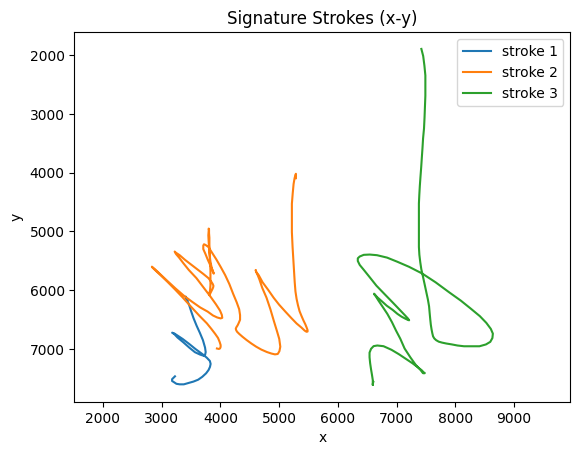

In [17]:
plot_strokes_xy(df_cleaned, title="Signature Strokes (x-y)")

## Encode Signature

### Subtask:
Define the `local_extrema` function and then encode the cleaned signature (`df_cleaned`) into a symbolic string representation using the `encode_signature` function.


**Reasoning**:
The subtask requires defining the `local_extrema` function and then using it indirectly via `encode_signature` to encode the cleaned signature. This code block will implement the `local_extrema` function as described and then execute the encoding.



In [18]:
def local_extrema(arr: np.ndarray) -> tuple[List[int], List[int]]:
    min_indices = []
    max_indices = []

    if len(arr) < 2:
        return min_indices, max_indices

    # Handle the first element
    if arr[0] < arr[1]:
        min_indices.append(0)
    elif arr[0] > arr[1]:
        max_indices.append(0)

    # Iterate through internal elements
    for i in range(1, len(arr) - 1):
        # Local minimum
        if arr[i-1] > arr[i] < arr[i+1]:
            min_indices.append(i)
        # Local maximum
        elif arr[i-1] < arr[i] > arr[i+1]:
            max_indices.append(i)

    # Handle the last element
    if arr[len(arr)-1] < arr[len(arr)-2]:
        min_indices.append(len(arr)-1)
    elif arr[len(arr)-1] > arr[len(arr)-2]:
        max_indices.append(len(arr)-1)

    return min_indices, max_indices

# Encode the cleaned signature
encoded_signature = encode_signature(df_cleaned)

# Print the encoded signature
print("Encoded Signature:", encoded_signature)

Encoded Signature: ['bcbdbcbd', 'acdcdbbcacadbdcd', 'bccccbac']


**Reasoning**:
The previous execution failed because 'np' was not defined. This indicates that the numpy library, aliased as 'np', was not imported before being used. I need to add `import numpy as np` at the beginning of the code block to resolve this `NameError`.



In [20]:
import numpy as np

def local_extrema(arr: np.ndarray) -> tuple[List[int], List[int]]:
    min_indices = []
    max_indices = []

    if len(arr) < 2:
        return min_indices, max_indices

    # Handle the first element
    if arr[0] < arr[1]:
        min_indices.append(0)
    elif arr[0] > arr[1]:
        max_indices.append(0)

    # Iterate through internal elements
    for i in range(1, len(arr) - 1):
        # Local minimum
        if arr[i-1] > arr[i] < arr[i+1]:
            min_indices.append(i)
        # Local maximum
        elif arr[i-1] < arr[i] > arr[i+1]:
            max_indices.append(i)

    # Handle the last element
    if arr[len(arr)-1] < arr[len(arr)-2]:
        min_indices.append(len(arr)-1)
    elif arr[len(arr)-1] > arr[len(arr)-2]:
        max_indices.append(len(arr)-1)

    return min_indices, max_indices

# Encode the cleaned signature
encoded_signature = encode_signature(df_cleaned)

# Print the encoded signature
print("Encoded Signature:", encoded_signature)

Encoded Signature: ['bcbdbcbd', 'acdcdbbcacadbdcd', 'bccccbac']


In [21]:
normalized_dist = normalized_distance(encoded_signature, encoded_signature)
verification_threshold = 0.1
is_accepted = normalized_dist < verification_threshold

print("Normalized Levenshtein Distance (self-comparison):", normalized_dist)
print("Verification Threshold:", verification_threshold)
print("Signature Accepted:", is_accepted)

Normalized Levenshtein Distance (self-comparison): 0.0
Verification Threshold: 0.1
Signature Accepted: True
